In [1]:
# Scientific computing imports
import itertools
import numpy
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx
import pandas as pd
import seaborn; seaborn.set()

from shipnet_randv1_1 import MultiPlex,ShipNET
%matplotlib inline

In [2]:
# set directory

import os
import glob

os.chdir("C:\Users\colinsh\Documents\compship\Data")
os.listdir("./")

# Using glob to list the output directory
glob.glob("simpleship_wred_50/ship-*")[0:5]

WindowsError: [Error 3] The system cannot find the path specified: 'C:\\Users\\colinsh\\Documents\\compship\\Data'

In [7]:
all_data = pd.read_csv(os.path.join("simpleship_wred_50_ringbus", "series_type.csv"),index_col=None)
#all_data = pd.read_csv(os.path.join("simpleship_wred_50_auxmove", "series_type.csv"),index_col=None)
#all_data = pd.read_csv(os.path.join("simpleship_wred_50", "series_type.csv"),index_col=None)
#all_data = pd.read_csv(os.path.join("simpleship_all50", "series_all.csv"),index_col=None)
#all_data = pd.read_csv(os.path.join("warship_perm_noexc_fullh_trans", "series_all.csv"),index_col=None)
#type_data = pd.read_csv(os.path.join("simple_perm_noexc", "series_type.csv"),index_col=None)

IOError: File simpleship_wred_50_ringbus\series_type.csv does not exist

In [4]:
ship=ShipNET([8,3,6])
for x in range(2):
    for z in range (4,6):
        for y in range(3):
            ship.remove_ship_node((x,y,z))
for x in range(6,8):
    for z in range (4,6):
        for y in range(3):
            ship.remove_ship_node((x,y,z))
ship.remove_ship_node((0,0,0))
ship.remove_ship_node((0,1,0))
ship.remove_ship_node((0,2,0))

#Remove ship edges for bulkheads in ringbus configuration
ship.remove_ship_edge(((1,1,2),(2,1,2)))
ship.remove_ship_edge(((1,1,1),(2,1,1)))
ship.remove_ship_edge(((3,1,2),(4,1,2)))
ship.remove_ship_edge(((3,1,1),(4,1,1)))
ship.remove_ship_edge(((5,1,2),(6,1,2)))
ship.remove_ship_edge(((5,1,1),(6,1,1)))


nodes=[]
for n in ship.ship.nodes():
    nodes.append(str(n))

edges=[]
for e in ship.ship.edges():
    edges.append(str(e))

In [5]:
#Get number of system types on each edge
n_t_edges=numpy.log2(all_data[edges])

print n_t_edges.max().max()

NameError: name 'all_data' is not defined

In [6]:
#add in run data
e_type_data=pd.concat([all_data['num_bh'],all_data['height_dc'],all_data['redundancy'],all_data['permeability'],n_t_edges],1)

NameError: name 'all_data' is not defined

In [10]:
#delete off center edges
for column in e_type_data:
    if len(column)>15:
        #print column,column[5],column[16]
        if column[5]!='1' or column[16]!='1':
            e_type_data=e_type_data.drop(column,1)
            
#print e_type_data

In [11]:
#only look at 3 bulkheads, 2 redundancy
df=e_type_data.copy()

df=df[(df['num_bh']==0) & (df['redundancy']==1) & (df['permeability']==0)]
df=df.drop(['num_bh','height_dc','redundancy','permeability'],1)
print df.mean().var()



0.661244888082


In [ ]:
# convert df to network
g=nx.Graph()

non_bh_edges=[((7,1),(7,0)),((6,0),(7,0)),((6,0),(6,1))]

for c in df:
    e=((int(c[2]),int(c[8])),(int(c[13]),int(c[19])))
    w=df[c].mean()
    if (w!=0.0) or (e in non_bh_edges):
        g.add_edge(*e,weight=w)
    
#print g.edges(data=True)
    
#node list for locations
#comp_nodes=[(2,0),(4,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]
#comp_nodes=[(2,0),(3,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]

comp_nodes={
    (2,0):'MAIN',
    (4,0):'AUX', #(3,0) for moved AUX case; (4,0) otherwise
    (1,0):'PR_MVR',
    (5,0):'Chiller',
    (4,5):'Bridge',
    (4,3):'Comm',
    (5,3):'CIC_1',
    (2,3):'CIC_2',
    (0,3):'Def_1',
    (6,3):'Def_2',
    (2,5):'Def_3',
    (5,5):'Radar',
    (2,2):'Hotel_1',
    (5,2):'Hotel_2',
    (0,1):'Mach_1',
    (7,1):'Mach_2'    
}



In [ ]:
#draw graph
layout=dict(zip(g,g))
ymax=max(yy for xx, yy in layout.values())
e_weights=nx.get_edge_attributes(g,'weight')
widths=[g[u][v]['weight']+.5 for u,v in g.edges()]

layout_l={}
for n,pos in layout.iteritems():
    if n in comp_nodes:
        l=comp_nodes[n]
        #layout_l[n]=(pos[0]-.07*len(l),pos[1]+.2)
        
        if l=='PR_MVR':
            print 'found'
            layout_l[n]=(pos[0]-.6,pos[1]+.25)
        elif '_' in l:
            layout_l[n]=(pos[0]-.45,pos[1]+.25)
        else:
            layout_l[n]=(pos[0]-.4,pos[1]+.25)


    
print widths

plt.figure(figsize=(12,8))

nx.draw_networkx_edges(g,
                 pos=layout,
                 with_labels=False,
                 #width=widths
                      )
nx.draw_networkx_nodes(g,
                      pos=layout,
                      nodelist=comp_nodes)

nx.draw_networkx_labels(g,pos=layout_l,labels=comp_nodes,font_size=16)


#_=nx.draw_networkx_edge_labels(g,pos=layout,edge_labels=e_weights, font_size=13)

plt.axis('off')
#plt.title('Average number of systems routing through edge',fontsize=20,y=.95)
plt.savefig('C:/Users/colinsh/Documents/compship/Data/figs/ring_net.png')
#plt.savefig('C:/Users/colinsh/Documents/compship/Data/routedensity_auxmove_net.png')



In [ ]:
s='((7, 1, 3), (6, 1, 3))'
e=((int(s[2]),int(s[8])),(int(s[13]),int(s[19])))
print e

In [ ]:
#draw graph
layout=dict(zip(g,g))
ymax=max(yy for xx, yy in layout.values())
e_weights=nx.get_edge_attributes(g,'weight')
widths=[g[u][v]['weight']+.5 for u,v in g.edges()]

    
print widths

plt.figure(figsize=(12,8))

nx.draw_networkx_edges(g,
                 pos=layout,
                 with_labels=False,
                      )
nx.draw_networkx_nodes(g,
                      pos=layout,
                      nodelist=comp_nodes)

#_=nx.draw_networkx_edge_labels(g,pos=layout,edge_labels=e_weights, font_size=13)

plt.axis('off')
#plt.title('Average number of systems routing through edge',fontsize=20,y=.95)
plt.savefig('C:/Users/colinsh/Documents/compship/Data/simpleship_net.png')

In [ ]:
print layout

In [ ]:
print g.nodes(data=True)

In [3]:
### t-test and chi^2 test ###
r_data = pd.read_csv(os.path.join("simpleship_wred_50_ringbus", "series_type.csv"),index_col=None)
a_data = pd.read_csv(os.path.join("simpleship_wred_50_auxmove", "series_type.csv"),index_col=None)
o_data = pd.read_csv(os.path.join("simpleship_wred_50", "series_type.csv"),index_col=None)

#ship for ring bus
ship=ShipNET([8,3,6])
for x in range(2):
    for z in range (4,6):
        for y in range(3):
            ship.remove_ship_node((x,y,z))
for x in range(6,8):
    for z in range (4,6):
        for y in range(3):
            ship.remove_ship_node((x,y,z))
ship.remove_ship_node((0,0,0))
ship.remove_ship_node((0,1,0))
ship.remove_ship_node((0,2,0))

##Remove ship edges for bulkheads in ringbus configuration
ship.remove_ship_edge(((1,1,2),(2,1,2)))
ship.remove_ship_edge(((1,1,1),(2,1,1)))
ship.remove_ship_edge(((3,1,2),(4,1,2)))
ship.remove_ship_edge(((3,1,1),(4,1,1)))
ship.remove_ship_edge(((5,1,2),(6,1,2)))
ship.remove_ship_edge(((5,1,1),(6,1,1)))


r_nodes=[]
for n in ship.ship.nodes():
    r_nodes.append(str(n))

r_edges=[]
for e in ship.ship.edges():
    r_edges.append(str(e))
    
#ship for AUX and original    
ship=ShipNET([8,3,6])
for x in range(2):
    for z in range (4,6):
        for y in range(3):
            ship.remove_ship_node((x,y,z))
for x in range(6,8):
    for z in range (4,6):
        for y in range(3):
            ship.remove_ship_node((x,y,z))
ship.remove_ship_node((0,0,0))
ship.remove_ship_node((0,1,0))
ship.remove_ship_node((0,2,0))


nodes=[]
for n in ship.ship.nodes():
    nodes.append(str(n))

edges=[]
for e in ship.ship.edges():
    edges.append(str(e))
    
#### Manipulate to time series ####
## r
#Get number of system types on each edge
r_t_edges=numpy.log2(r_data[r_edges])
#add in run data
r_type_data=pd.concat([r_data['num_bh'],r_data['height_dc'],r_data['redundancy'],r_data['permeability'],r_t_edges],1)
#delete off center edges
for column in r_type_data:
    if len(column)>15:
        #print column,column[5],column[16]
        if column[5]!='1' or column[16]!='1':
            r_type_data=r_type_data.drop(column,1)
#cut by bulkhead data
r=r_type_data.copy()
r=r[(r['num_bh']==0) & (r['redundancy']==1) & (r['permeability']==0)]
r=r.drop(['num_bh','height_dc','redundancy','permeability'],1)
print 'r, mean={}, var={}'.format(r.mean().mean(), r.mean().var())

## a
#Get number of system types on each edge
a_t_edges=numpy.log2(a_data[edges])
#add in run data
a_type_data=pd.concat([a_data['num_bh'],a_data['height_dc'],a_data['redundancy'],a_data['permeability'],a_t_edges],1)
#delete off center edges
for column in a_type_data:
    if len(column)>15:
        #print column,column[5],column[16]
        if column[5]!='1' or column[16]!='1':
            a_type_data=a_type_data.drop(column,1)
#cut by bulkhead data
a=a_type_data.copy()
a=a[(a['num_bh']==3) & (a['redundancy']==1) & (a['permeability']==0)]
a=a.drop(['num_bh','height_dc','redundancy','permeability'],1)
#print 'a',a.mean().var()
print 'a, mean={}, var={}'.format(a.mean().mean(), a.mean().var())



## o
#Get number of system types on each edge
o_t_edges=numpy.log2(o_data[edges])
#add in run data
o_type_data=pd.concat([o_data['num_bh'],o_data['height_dc'],o_data['redundancy'],o_data['permeability'],o_t_edges],1)
#delete off center edges
for column in o_type_data:
    if len(column)>15:
        #print column,column[5],column[16]
        if column[5]!='1' or column[16]!='1':
            o_type_data=o_type_data.drop(column,1)
#cut by bulkhead data
o=o_type_data.copy()
o=o[(o['num_bh']==3) & (o['redundancy']==1) & (o['permeability']==0)]
o=o.drop(['num_bh','height_dc','redundancy','permeability'],1)
#print 'o',o.mean().var()
print 'o, mean={}, var={}'.format(o.mean().mean(), o.mean().var())


r 0.661244888082
a 1.67196468254
o 1.9730015873


In [27]:
#### Statistical Analysis ####
from scipy.stats import stats

print stats.ttest_ind(o.mean(),a.mean(),equal_var=False)
print stats.ttest_ind(o.mean(),r.mean(),equal_var=False)
print stats.ttest_ind(a.mean(),r.mean(),equal_var=False)

print stats.ranksums(o.mean(),a.mean())
print stats.ranksums(o.mean(),r.mean())
print stats.ranksums(a.mean(),r.mean())

#print stats.f_oneway(o.mean(),a.mean(),r.mean())

print stats.ttest_1samp(r.mean(),r.mean().mean())


Ttest_indResult(statistic=0.22784657260988136, pvalue=0.82013735950499123)
Ttest_indResult(statistic=-1.5376950918502843, pvalue=0.12719883621450087)
Ttest_indResult(statistic=-1.9119208981011646, pvalue=0.058551425877583815)
RanksumsResult(statistic=-0.047655803228938962, pvalue=0.96199055796782473)
RanksumsResult(statistic=-1.2124538826602009, pvalue=0.22533868573991711)
RanksumsResult(statistic=-1.2919170335322225, pvalue=0.19638587817960851)
Ttest_1sampResult(statistic=0.0, pvalue=1.0)


In [67]:
#Open PDF
pp = PdfPages('C:/Users/colinsh/Documents/compship/Data/density.pdf')


In [68]:
size=(16,8)

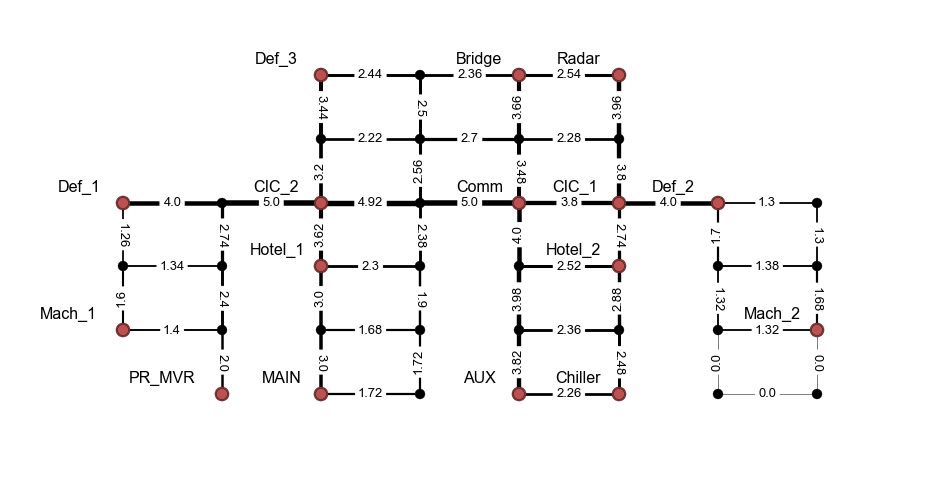

In [69]:
#Original convert df to network
g_o=nx.Graph()

non_bh_edges=[((7,1),(7,0)),((6,0),(7,0)),((6,0),(6,1))]

for c in o:
    e=((int(c[2]),int(c[8])),(int(c[13]),int(c[19])))
    w=o[c].mean()
    if (w!=0.0) or (e in non_bh_edges):
        g_o.add_edge(*e,weight=w)
    
#print g.edges(data=True)
    
#node list for locations
#comp_nodes=[(2,0),(4,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]
#comp_nodes=[(2,0),(3,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]

comp_nodes={
    (2,0):'MAIN',
    (4,0):'AUX', #(3,0) for moved AUX case; (4,0) otherwise
    (1,0):'PR_MVR',
    (5,0):'Chiller',
    (4,5):'Bridge',
    (4,3):'Comm',
    (5,3):'CIC_1',
    (2,3):'CIC_2',
    (0,3):'Def_1',
    (6,3):'Def_2',
    (2,5):'Def_3',
    (5,5):'Radar',
    (2,2):'Hotel_1',
    (5,2):'Hotel_2',
    (0,1):'Mach_1',
    (7,1):'Mach_2'    
}


#Get Layout
ratio=1
layout=dict(zip(g_o,g_o))
for n,v in layout.iteritems():
    layout[n]=(v[0]*ratio,v[1])
    
#print layout


#draw graph
ymax=max(yy for xx, yy in layout.values())
e_weights=nx.get_edge_attributes(g_o,'weight')
widths=[g_o[u][v]['weight']+.5 for u,v in g_o.edges()]

layout_l={}
for n,pos in layout.iteritems():
    if n in comp_nodes:
        l=comp_nodes[n]
        #layout_l[n]=(pos[0]-.07*len(l),pos[1]+.2)
        
        if l=='PR_MVR':
            #print 'found'
            layout_l[n]=(pos[0]-.6,pos[1]+.25)
        elif '_' in l:
            layout_l[n]=(pos[0]-.45,pos[1]+.25)
        else:
            layout_l[n]=(pos[0]-.4,pos[1]+.25)
            
        if l=='Mach_1':
            layout_l[n]=(pos[0]-.55,pos[1]+.25)

#Get Layout
ratio=1
layout=dict(zip(g_o,g_o))
for n,v in layout.iteritems():
    layout[n]=(v[0]*ratio,v[1])
    
#print widths

plt.figure(figsize=size)

nx.draw_networkx_edges(g_o,
                 pos=layout,
                 with_labels=False,
                 width=widths
                      )

nx.draw_networkx_nodes(g_o,
                      pos=layout,
                      nodelist=g_o.nodes(),
                      node_color='k',
                      node_size=100)

nx.draw_networkx_nodes(g_o,
                      pos=layout,
                      nodelist=comp_nodes,
                      node_size=200,
                      node_color=(140.0/256,56.0/256,54.0/256))

nx.draw_networkx_nodes(g_o,
                      pos=layout,
                      nodelist=comp_nodes,
                      node_size=120,
                      node_color=(192.0/256,80.0/256,77.0/256))

nx.draw_networkx_labels(g_o,pos=layout_l,labels=comp_nodes,font_size=16)


_=nx.draw_networkx_edge_labels(g_o,pos=layout,edge_labels=e_weights, font_size=13)

plt.axis('off')

pp.savefig()

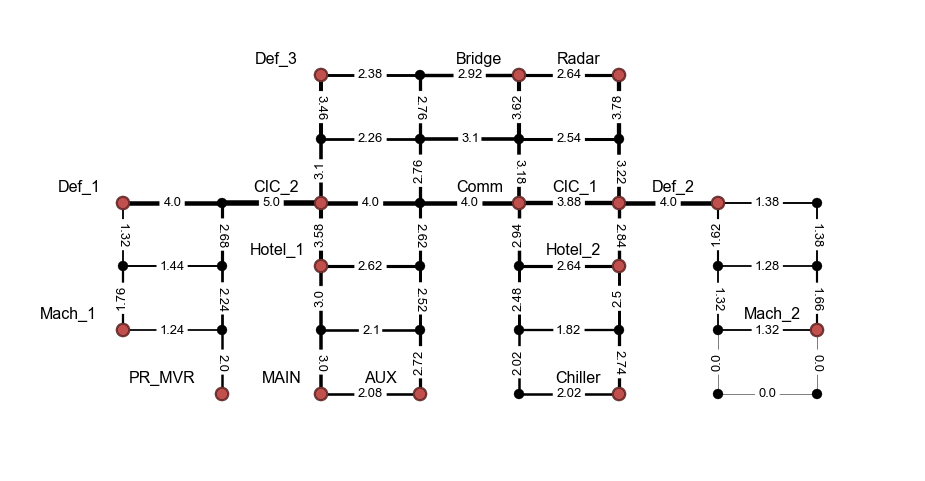

In [70]:
#AUX convert df to network
g_a=nx.Graph()

non_bh_edges=[((7,1),(7,0)),((6,0),(7,0)),((6,0),(6,1))]

for c in a:
    e=((int(c[2]),int(c[8])),(int(c[13]),int(c[19])))
    w=a[c].mean()
    if (w!=0.0) or (e in non_bh_edges):
        g_a.add_edge(*e,weight=w)
    
#print g.edges(data=True)
    
#node list for locations
#comp_nodes=[(2,0),(4,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]
#comp_nodes=[(2,0),(3,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]

comp_nodes={
    (2,0):'MAIN',
    (3,0):'AUX', #(3,0) for moved AUX case; (4,0) otherwise
    (1,0):'PR_MVR',
    (5,0):'Chiller',
    (4,5):'Bridge',
    (4,3):'Comm',
    (5,3):'CIC_1',
    (2,3):'CIC_2',
    (0,3):'Def_1',
    (6,3):'Def_2',
    (2,5):'Def_3',
    (5,5):'Radar',
    (2,2):'Hotel_1',
    (5,2):'Hotel_2',
    (0,1):'Mach_1',
    (7,1):'Mach_2'    
}


#Get Layout
ratio=1
layout=dict(zip(g_a,g_a))
for n,v in layout.iteritems():
    layout[n]=(v[0]*ratio,v[1])
    
#print layout


#draw graph
ymax=max(yy for xx, yy in layout.values())
e_weights=nx.get_edge_attributes(g_a,'weight')
widths=[g_a[u][v]['weight']+.5 for u,v in g_a.edges()]

layout_l={}
for n,pos in layout.iteritems():
    if n in comp_nodes:
        l=comp_nodes[n]
        #layout_l[n]=(pos[0]-.07*len(l),pos[1]+.2)
        
        if l=='PR_MVR':
            #print 'found'
            layout_l[n]=(pos[0]-.6,pos[1]+.25)
        elif '_' in l:
            layout_l[n]=(pos[0]-.45,pos[1]+.25)
        else:
            layout_l[n]=(pos[0]-.4,pos[1]+.25)
            
        if l=='Mach_1':
            layout_l[n]=(pos[0]-.55,pos[1]+.25)


#print widths

plt.figure(figsize=size)

nx.draw_networkx_edges(g_a,
                 pos=layout,
                 with_labels=False,
                 width=widths
                      )

nx.draw_networkx_nodes(g_a,
                      pos=layout,
                      nodelist=g_o.nodes(),
                      node_color='k',
                      node_size=100)

nx.draw_networkx_nodes(g_a,
                      pos=layout,
                      nodelist=comp_nodes,
                      node_size=200,
                      node_color=(140.0/256,56.0/256,54.0/256))

nx.draw_networkx_nodes(g_a,
                      pos=layout,
                      nodelist=comp_nodes,
                      node_size=120,
                      node_color=(192.0/256,80.0/256,77.0/256))

nx.draw_networkx_labels(g_a,pos=layout_l,labels=comp_nodes,font_size=16)


_=nx.draw_networkx_edge_labels(g_a,pos=layout,edge_labels=e_weights, font_size=13)

plt.axis('off')

pp.savefig()

{(7, 3): (7, 3), (1, 3): (1, 3), (3, 0): (3, 0), (3, 2): (3, 2), (2, 1): (2, 1), (6, 2): (6, 2), (5, 1): (5, 1), (0, 3): (0, 3), (2, 5): (2, 5), (7, 2): (7, 2), (4, 0): (4, 0), (1, 2): (1, 2), (3, 3): (3, 3), (4, 4): (4, 4), (6, 3): (6, 3), (5, 0): (5, 0), (2, 2): (2, 2), (3, 4): (3, 4), (5, 3): (5, 3), (4, 1): (4, 1), (1, 1): (1, 1), (5, 4): (5, 4), (7, 1): (7, 1), (4, 5): (4, 5), (6, 0): (6, 0), (2, 3): (2, 3), (4, 2): (4, 2), (1, 0): (1, 0), (3, 5): (3, 5), (0, 1): (0, 1), (7, 0): (7, 0), (5, 5): (5, 5), (6, 1): (6, 1), (3, 1): (3, 1), (2, 4): (2, 4), (2, 0): (2, 0), (4, 3): (4, 3), (5, 2): (5, 2), (0, 2): (0, 2)}


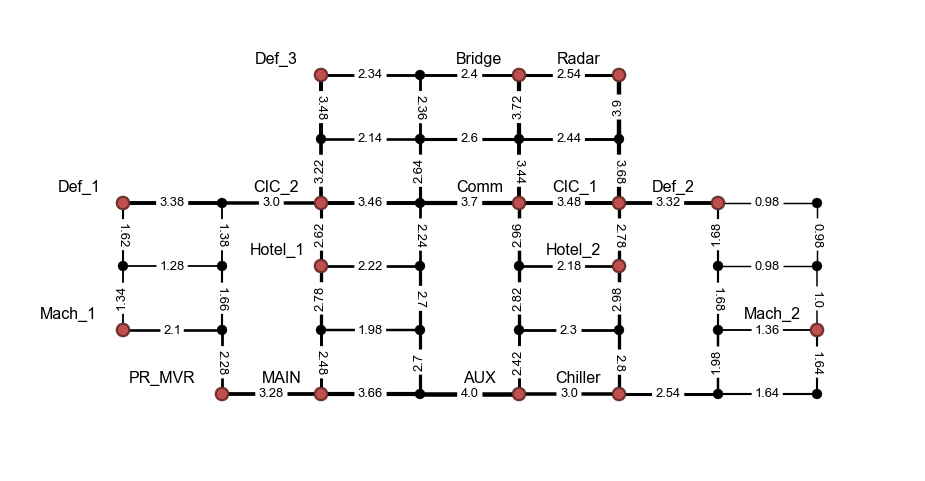

In [71]:
#Ring-bus convert df to network
g_r=nx.Graph()

non_bh_edges=[((7,1),(7,0)),((6,0),(7,0)),((6,0),(6,1))]

for c in r:
    e=((int(c[2]),int(c[8])),(int(c[13]),int(c[19])))
    w=r[c].mean()
    if (w!=0.0) or (e in non_bh_edges):
        g_r.add_edge(*e,weight=w)
    
#print g.edges(data=True)
    
#node list for locations
#comp_nodes=[(2,0),(4,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]
#comp_nodes=[(2,0),(3,0),(1,0),(5,0),(4,5),(4,3),(5,3),(2,3),(0,3),(6,3),(2,5),(5,5),(2,2),(5,2),(0,1),(7,1)]

comp_nodes={
    (2,0):'MAIN',
    (4,0):'AUX', #(3,0) for moved AUX case; (4,0) otherwise
    (1,0):'PR_MVR',
    (5,0):'Chiller',
    (4,5):'Bridge',
    (4,3):'Comm',
    (5,3):'CIC_1',
    (2,3):'CIC_2',
    (0,3):'Def_1',
    (6,3):'Def_2',
    (2,5):'Def_3',
    (5,5):'Radar',
    (2,2):'Hotel_1',
    (5,2):'Hotel_2',
    (0,1):'Mach_1',
    (7,1):'Mach_2'    
}


#Get Layout
ratio=1
layout=dict(zip(g_r,g_r))
for n,v in layout.iteritems():
    layout[n]=(v[0]*ratio,v[1])
    
print layout


#draw graph
ymax=max(yy for xx, yy in layout.values())
e_weights=nx.get_edge_attributes(g_r,'weight')
widths=[g_r[u][v]['weight']+.5 for u,v in g_r.edges()]

layout_l={}
for n,pos in layout.iteritems():
    if n in comp_nodes:
        l=comp_nodes[n]
        #layout_l[n]=(pos[0]-.07*len(l),pos[1]+.2)
        
        if l=='PR_MVR':
            #print 'found'
            layout_l[n]=(pos[0]-.6,pos[1]+.25)
        elif '_' in l:
            layout_l[n]=(pos[0]-.45,pos[1]+.25)
        else:
            layout_l[n]=(pos[0]-.4,pos[1]+.25)
            
        if l=='Mach_1':
            layout_l[n]=(pos[0]-.55,pos[1]+.25)

#Get Layout
ratio=1
layout=dict(zip(g_r,g_r))
for n,v in layout.iteritems():
    layout[n]=(v[0]*ratio,v[1])
    
#print widths

plt.figure(figsize=size)

nx.draw_networkx_edges(g_r,
                 pos=layout,
                 with_labels=False,
                 width=widths
                      )

nx.draw_networkx_nodes(g_r,
                      pos=layout,
                      nodelist=g_o.nodes(),
                      node_color='k',
                      node_size=100)

nx.draw_networkx_nodes(g_r,
                      pos=layout,
                      nodelist=comp_nodes,
                      node_size=200,
                      node_color=(140.0/256,56.0/256,54.0/256))

nx.draw_networkx_nodes(g_r,
                      pos=layout,
                      nodelist=comp_nodes,
                      node_size=120,
                      node_color=(192.0/256,80.0/256,77.0/256))

nx.draw_networkx_labels(g_r,pos=layout_l,labels=comp_nodes,font_size=16)


_=nx.draw_networkx_edge_labels(g_r,pos=layout,edge_labels=e_weights, font_size=13)

plt.axis('off')

pp.savefig()

In [72]:
# Close PDF
pp.close()